In [1]:
import copy
from pathlib import Path
from time import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from tqdm.notebook import trange

from kgi import apply_kgi_to_model

In [2]:
# attempt to enable LaTeX rendering
# change to `False` if you get an error during plotting (latex not installed)
plt.rcParams['text.usetex'] = True

In [3]:
def default_init_to_he_uniform(model):
    """ Change PyTorch's default initialization to He uniform """
    # PyTorch default uses 1/sqrt(m) as the bound
    # He uniform uses sqrt(3)/sqrt(m) as the bound
    sqrt3 = np.sqrt(3)
    for layer in model.modules():
        if isinstance(layer, torch.nn.Linear):
            layer.weight.data *= sqrt3
            layer.bias.data *= sqrt3


class MLP(nn.Module):
    """ MLP model """

    def __init__(self, input_size, hidden_size, num_hidden_layers=1, activation=torch.relu):
        super(MLP, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(hidden_size, hidden_size) for _ in range(num_hidden_layers)]
        )
        self.output_layer = nn.Linear(hidden_size, 1)
        self.act = activation
        default_init_to_he_uniform(self)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.act(x)
        for layer in self.hidden_layers:
            x = layer(x)
            x = self.act(x)
        x = self.output_layer(x)
        return x

# Visualize initialized models

In [4]:
def find_knots(y, dx, threshold=1e-5):
    """ Find indices of knots on a surface """
    # neighbours
    z_me = y[1:-1, 1:-1]
    z_vp = y[2:, 1:-1]
    z_vm = y[:-2, 1:-1]
    z_hp = y[1:-1, 2:]
    z_hm = y[1:-1, :-2]
    x_me = torch.zeros_like(z_me)
    y_me = torch.zeros_like(z_me)
    x_vp = x_me
    y_vp = y_me + dx
    x_vm = x_me
    y_vm = y_me - dx
    x_hp = x_me + dx
    y_hp = y_me
    x_hm = x_me - dx
    y_hm = y_me
    xyz_me = torch.stack([x_me, y_me, z_me], dim=-1)
    xyz_vp = torch.stack([x_vp, y_vp, z_vp], dim=-1)
    xyz_vm = torch.stack([x_vm, y_vm, z_vm], dim=-1)
    xyz_hp = torch.stack([x_hp, y_hp, z_hp], dim=-1)
    xyz_hm = torch.stack([x_hm, y_hm, z_hm], dim=-1)
    v_vp = xyz_vp - xyz_me
    v_vm = xyz_vm - xyz_me
    v_hp = xyz_hp - xyz_me
    v_hm = xyz_hm - xyz_me
    norm1 = torch.cross(v_vp, v_hp, dim=-1)
    norm2 = torch.cross(v_hp, v_vm, dim=-1)
    norm3 = torch.cross(v_vm, v_hm, dim=-1)
    norm4 = torch.cross(v_hm, v_vp, dim=-1)
    norm1 /= torch.norm(norm1, dim=-1)[:, :, None]
    norm2 /= torch.norm(norm2, dim=-1)[:, :, None]
    norm3 /= torch.norm(norm3, dim=-1)[:, :, None]
    norm4 /= torch.norm(norm4, dim=-1)[:, :, None]
    comparison12 = torch.isclose(norm1, norm2, atol=threshold, rtol=0)
    comparison13 = torch.isclose(norm1, norm3, atol=threshold, rtol=0)
    comparison14 = torch.isclose(norm1, norm4, atol=threshold, rtol=0)
    all_same = comparison12 & comparison13 & comparison14
    is_knot = torch.logical_not(torch.all(all_same, dim=-1))
    knots = torch.stack(torch.where(is_knot), dim=-1) + 1
    return knots

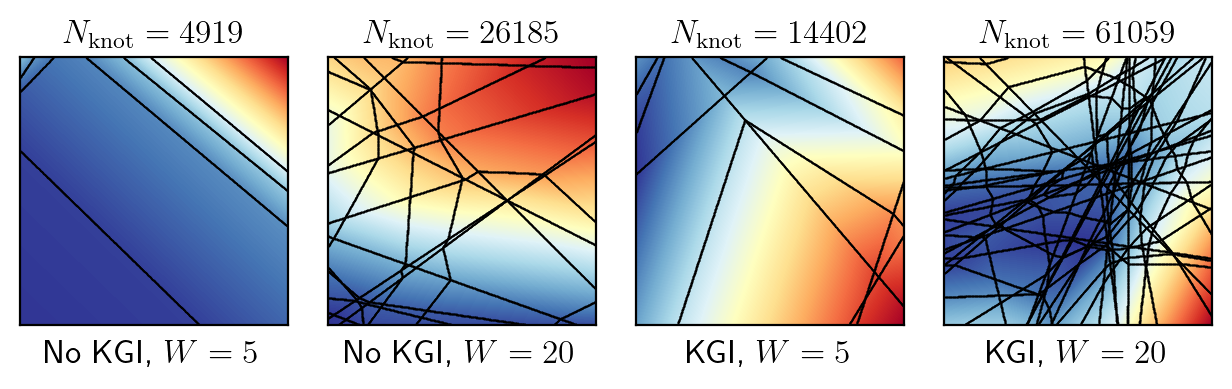

In [5]:
# use double for more accurate knot finding
torch.set_default_dtype(torch.float64)
torch.manual_seed(42)

# set number of surfaces
n_surface = 10

# hidden sizes to consider
n_hidden = [5, 20]

# input
n_grid = 1000
x_in = torch.linspace(0, 1, n_grid)
x_in = torch.stack(torch.meshgrid(x_in, x_in, indexing="ij"), dim=-1).reshape([-1, 2])

fig, axes = plt.subplots(1, 2 * len(n_hidden), figsize=(10 / 1.3, 3 / 1.3), dpi=200)
plt.subplots_adjust(wspace=.15)
for i_n, n in enumerate(n_hidden):
    n_knots_def = 0
    n_knots_kgi = 0
    for i in range(n_surface):
        # default model
        model_def = MLP(2, hidden_size=n)
        model_def.eval()

        # KGI model
        model_kgi = copy.deepcopy(model_def)
        apply_kgi_to_model(model_kgi, knot_low=0.2, knot_high=0.8,
                           perturb_factor=0.2, kgi_by_bias=False)

        # forward
        with torch.no_grad():
            y_def = model_def(x_in).reshape([n_grid, n_grid])
            y_kgi = model_kgi(x_in).reshape([n_grid, n_grid])

        # find knots
        knots_def = find_knots(y_def, 1 / n_grid)
        knots_kgi = find_knots(y_kgi, 1 / n_grid)
        n_knots_def += len(knots_def)
        n_knots_kgi += len(knots_kgi)

        # plot
        if i == 6:
            axes[i_n + 0].imshow(y_def, cmap='RdYlBu')
            axes[i_n + 0].scatter(knots_def[:, 1], knots_def[:, 0], marker=".",
                                  s=1, c='k', lw=0, rasterized=True)
            axes[i_n + 2].imshow(y_kgi, cmap='RdYlBu')
            axes[i_n + 2].scatter(knots_kgi[:, 1], knots_kgi[:, 0], marker=".",
                                  s=1, c='k', lw=0, rasterized=True)

    # title
    axes[i_n + 0].text(x=0.5, y=-0.14,
                       s="No KGI, $W=%d$" % (n,),
                       fontsize=12, ha='center',
                       transform=axes[i_n + 0].transAxes)
    axes[i_n + 0].text(x=0.5, y=1.03,
                       s="$N_\\mathrm{knot}=%d$" % (round(n_knots_def / n_surface),),
                       fontsize=12, ha='center', va='bottom',
                       transform=axes[i_n + 0].transAxes)
    axes[i_n + 2].text(x=0.5, y=-0.14,
                       s="KGI, $W=%d$" % (n,),
                       fontsize=12, ha='center',
                       transform=axes[i_n + 2].transAxes)
    axes[i_n + 2].text(x=0.5, y=1.03,
                       s="$N_\\mathrm{knot}=%d$" % (round(n_knots_kgi / n_surface),),
                       fontsize=12, ha='center', va='bottom',
                       transform=axes[i_n + 2].transAxes)

# setup
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
plt.savefig("figs/surface_knots.pdf", bbox_inches='tight', pad_inches=0.01)
plt.show()

# Surface fitting

## Target

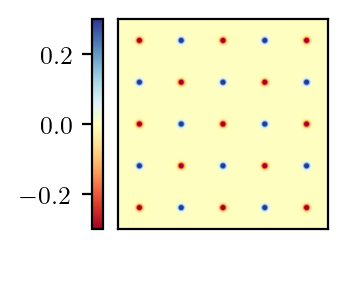

In [6]:
torch.set_default_dtype(torch.float32)


def gaussian(x, mu, sigma, height):
    """ Gaussian shape """
    mu = torch.tensor(mu)[None, :]
    exponent = -((x - mu).norm(dim=-1) ** 2) / (2 * sigma ** 2)
    return height * torch.exp(exponent)


# ground truth
n_grid = 200  # using smaller size for training
x_in = torch.linspace(0, 1, n_grid)
x_in = torch.stack(torch.meshgrid(x_in, x_in, indexing="ij"), dim=-1).reshape([-1, 2])
y_true = torch.zeros_like(x_in[:, 0])
for ix, xc in enumerate([0.1, 0.3, 0.5, 0.7, 0.9]):
    for iy, yc in enumerate([0.1, 0.3, 0.5, 0.7, 0.9]):
        y_true += gaussian(x_in, [xc, yc], 0.01, (ix + iy) % 2 - .5)

# plot
fig = plt.figure(figsize=(10 / 2.2 * 0.5, 3 / 2.2), dpi=200)
ax2 = fig.gca()
ax2.set_xticks([0, .5, 1.])
ax2.set_yticks([0, .5, 1.])
cax = ax2.imshow(y_true.reshape([n_grid, n_grid]), extent=[0, 1, 0, 1],
                 aspect=1, cmap='RdYlBu', vmin=-0.3, vmax=0.3)
cbar = fig.colorbar(cax, ax=ax2, orientation='vertical', pad=-.67)
cbar.ax.yaxis.set_ticks_position('left')
cbar.ax.tick_params(labelsize=9)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.text(.5, -.13, "Data", ha="center", c="w")
plt.savefig("figs/surface_target.pdf", bbox_inches='tight', pad_inches=0.01)
plt.show()

## Training

In [7]:
def train(kgi, hidden_size, num_hidden_layers, seed, activation=torch.relu,
          num_epochs=10000, log_loss_every=20, device="cpu", pbar=True):
    """ Train a model """
    torch.manual_seed(seed)
    model = MLP(2, hidden_size=hidden_size, num_hidden_layers=num_hidden_layers,
                activation=activation)
    if kgi:
        if activation is torch.nn.functional.tanh:
            apply_kgi_to_model(model,
                               knot_low=[0.2] + [-0.8] * (num_hidden_layers + 1),
                               knot_high=[0.8] * (num_hidden_layers + 2),
                               perturb_factor=0.2, kgi_by_bias=False)
        elif activation is torch.nn.functional.gelu:
            apply_kgi_to_model(model, knot_low=0.0, knot_high=1.0,
                               perturb_factor=0.2, kgi_by_bias=False)
        else:
            apply_kgi_to_model(model, knot_low=0.2, knot_high=0.8,
                               perturb_factor=0.2, kgi_by_bias=False)
    model.to(device)
    model.train()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # training loop
    loss_hist = []
    x_in_ = x_in.to(device)
    y_true_ = y_true.unsqueeze(1).to(device)
    for epoch in trange(num_epochs, disable=not pbar):
        y_pred = model(x_in_)
        loss = criterion(y_pred, y_true_)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (epoch + 1) % log_loss_every == 0:
            loss_hist.append(loss.item())
    return model, loss_hist

In [8]:
# train all models
reproduce_paper = True
if reproduce_paper:
    """ THIS WILL TAKE A LONG TIME TO TRAIN THE 10x10x4x2 MODELS """
    seeds = list(range(10))
    nn_sizes = [(25, 1), (50, 1), (100, 1), (200, 1), (400, 1), (600, 1),
                (25, 2), (25, 3), (25, 4), (25, 5)]
    activations = [torch.nn.functional.relu, torch.nn.functional.leaky_relu,
                   torch.nn.functional.gelu, torch.nn.functional.tanh]
    epochs = 60000
    device_ = "cuda"
    out_dir = Path("results/surface_paper")
    show_pbar = False
else:
    seeds = [0]
    nn_sizes = [(200, 1)]
    activations = [torch.nn.functional.relu]
    epochs = 3000
    device_ = "cpu"
    out_dir = Path("results/surface_test")
    show_pbar = True

out_dir.mkdir(exist_ok=True, parents=True)
for seed_ in seeds:
    for act_ in activations:
        for hidden_size_, num_hidden_layers_ in nn_sizes:
            for kgi_ in [False, True]:
                act_name_ = "gelu" if act_ is torch.nn.functional.gelu else str(act_).split(" ")[1]
                name_ = f"{act_name_}_{seed_}_{hidden_size_}_{num_hidden_layers_}_{kgi_}"
                if not (out_dir / name_).exists():
                    t0 = time()
                    _, hist_ = train(kgi_, hidden_size_, num_hidden_layers_, seed_, act_, device=device_,
                                     num_epochs=epochs, pbar=show_pbar)
                    np.savetxt(out_dir / name_, hist_)
                    print(f"{name_} trained in {(time() - t0) / 60:.1f} min, loss={hist_[-1]:.2e}")
                else:
                    print(f"{name_} exists")

relu_0_25_1_False exists
relu_0_25_1_True exists
relu_0_50_1_False exists
relu_0_50_1_True exists
relu_0_100_1_False exists
relu_0_100_1_True exists
relu_0_200_1_False exists
relu_0_200_1_True exists
relu_0_400_1_False exists
relu_0_400_1_True exists
relu_0_600_1_False exists
relu_0_600_1_True exists
relu_0_25_2_False exists
relu_0_25_2_True exists
relu_0_25_3_False exists
relu_0_25_3_True exists
relu_0_25_4_False exists
relu_0_25_4_True exists
relu_0_25_5_False exists
relu_0_25_5_True exists
leaky_relu_0_25_1_False exists
leaky_relu_0_25_1_True exists
leaky_relu_0_50_1_False exists
leaky_relu_0_50_1_True exists
leaky_relu_0_100_1_False exists
leaky_relu_0_100_1_True exists
leaky_relu_0_200_1_False exists
leaky_relu_0_200_1_True exists
leaky_relu_0_400_1_False exists
leaky_relu_0_400_1_True exists
leaky_relu_0_600_1_False exists
leaky_relu_0_600_1_True exists
leaky_relu_0_25_2_False exists
leaky_relu_0_25_2_True exists
leaky_relu_0_25_3_False exists
leaky_relu_0_25_3_True exists
leaky_

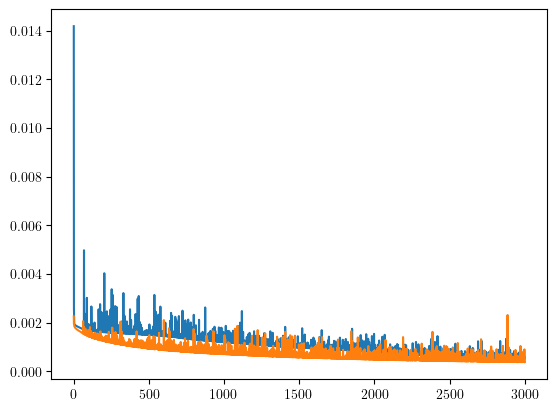

In [9]:
# quick comparison
hist_def = np.loadtxt(out_dir / "relu_0_200_1_False")
hist_kgi = np.loadtxt(out_dir / "relu_0_200_1_True")
plt.plot(hist_def)
plt.plot(hist_kgi)
plt.show()

## Analysis

The following cells works only when `reproduce_paper` was set `True` for training.

In [10]:
seeds = list(range(10))
nn_sizes = [(25, 1), (50, 1), (100, 1), (200, 1), (400, 1), (600, 1),
            (25, 2), (25, 3), (25, 4), (25, 5)]
epochs = 60000
out_dir = Path("results/surface_paper")

### Loss statistics

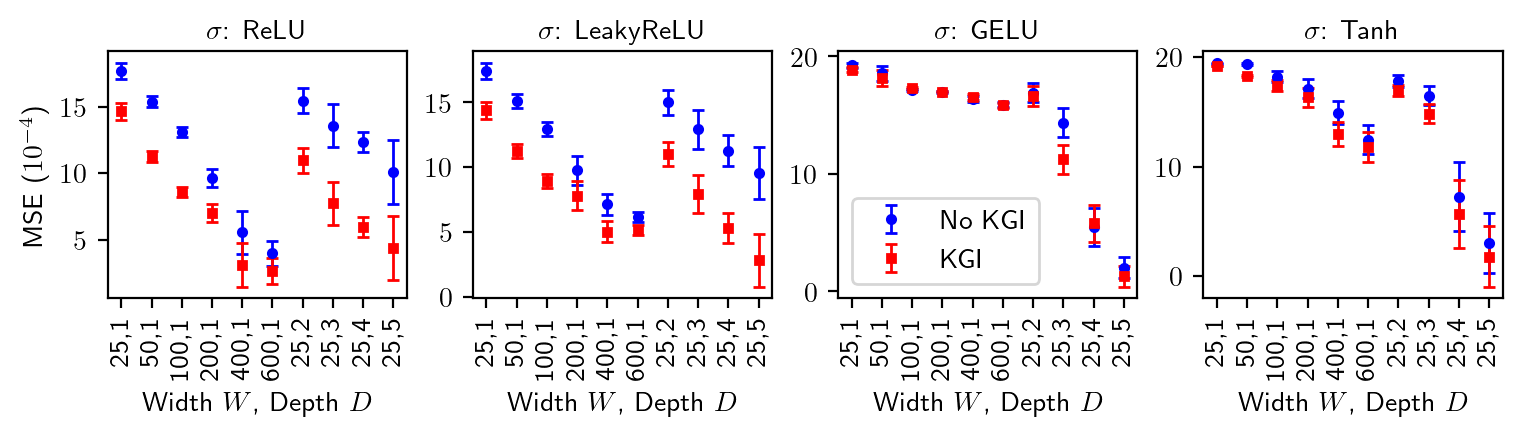

In [11]:
def get_metrics(act_name, kgi):
    min_loss_mean = []
    min_loss_std = []
    for hidden_size, num_hidden_layers in nn_sizes:
        hists = []
        for seed in seeds:
            name = f"{act_name}_{seed}_{hidden_size}_{num_hidden_layers}_{kgi}"
            hist = np.loadtxt(out_dir / name)
            hists.append(hist)
        hists = np.array(hists)[:, :1500] * 10000
        min_loss = np.mean(hists[:, -5:], axis=1)
        min_loss = np.sort(min_loss)
        min_loss_mean.append(min_loss[:-1].mean())
        min_loss_std.append(min_loss[:-1].std())
    return np.array(min_loss_mean), np.array(min_loss_std)


fig, axes = plt.subplots(1, 4, figsize=(9, 1.6), dpi=200, sharex=True)
plt.subplots_adjust(wspace=.22)
for i, (act, act_str) in enumerate(zip(["relu", "leaky_relu", "gelu", "tanh"],
                                       ["ReLU", "LeakyReLU", "GELU", "Tanh"])):
    min_mean_def, min_std_def = get_metrics(act, False)
    min_mean_kgi, min_std_kgi = get_metrics(act, True)
    x_fake = range(len(min_mean_def))
    axes[i].errorbar(x_fake, min_mean_def, min_std_def, fmt="o",
                     markersize=3, capsize=2, capthick=1, elinewidth=1, label="No KGI", c="b")
    axes[i].errorbar(x_fake, min_mean_kgi, min_std_def, fmt="s",
                     markersize=3, capsize=2, capthick=1, elinewidth=1, label="KGI", c="r")
    axes[i].set_xticks(x_fake, ["25,1", "50,1", "100,1", "200,1", "400,1", "600,1",
                                "25,2", "25,3", "25,4", "25,5"])
    for label in axes[i].get_xticklabels():
        label.set_rotation(90)
    axes[i].set_xlabel("Width $W$, Depth $D$")
    axes[i].text(.5, 1.03, f"$\sigma$: {act_str}", va="bottom", ha="center",
                 transform=axes[i].transAxes)

axes[0].set_ylabel("MSE ($10^{-4}$)")
axes[2].legend()
plt.savefig("figs/surface_loss_WD.pdf", bbox_inches='tight', pad_inches=0.01)
plt.show()

### Loss history

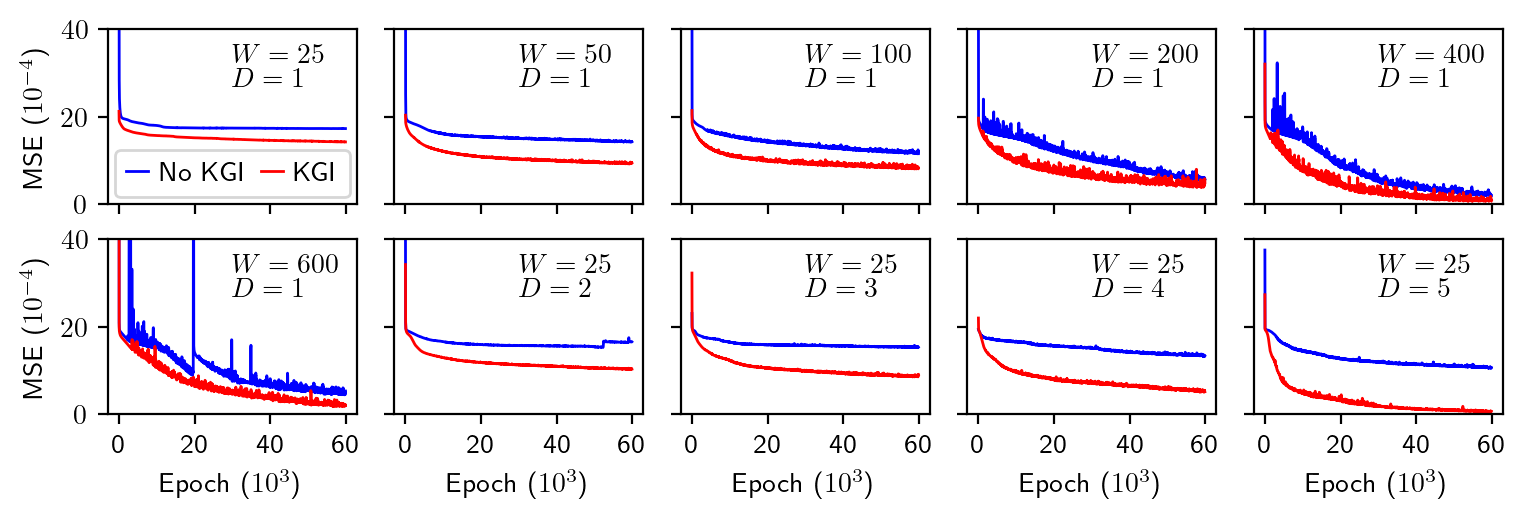

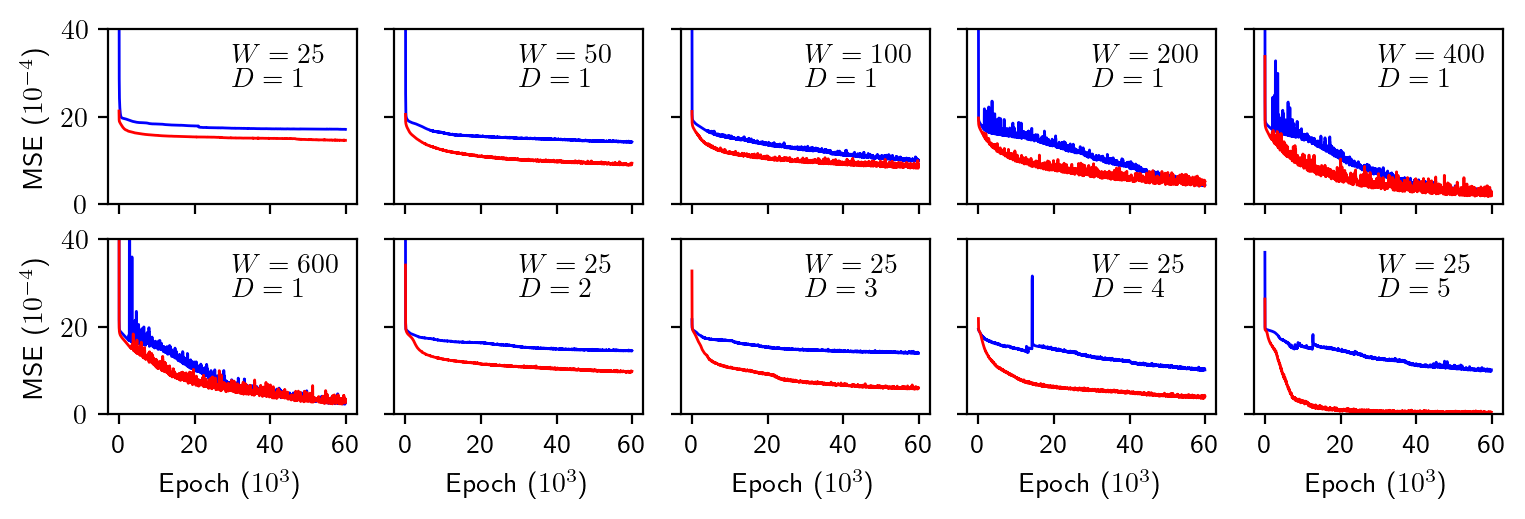

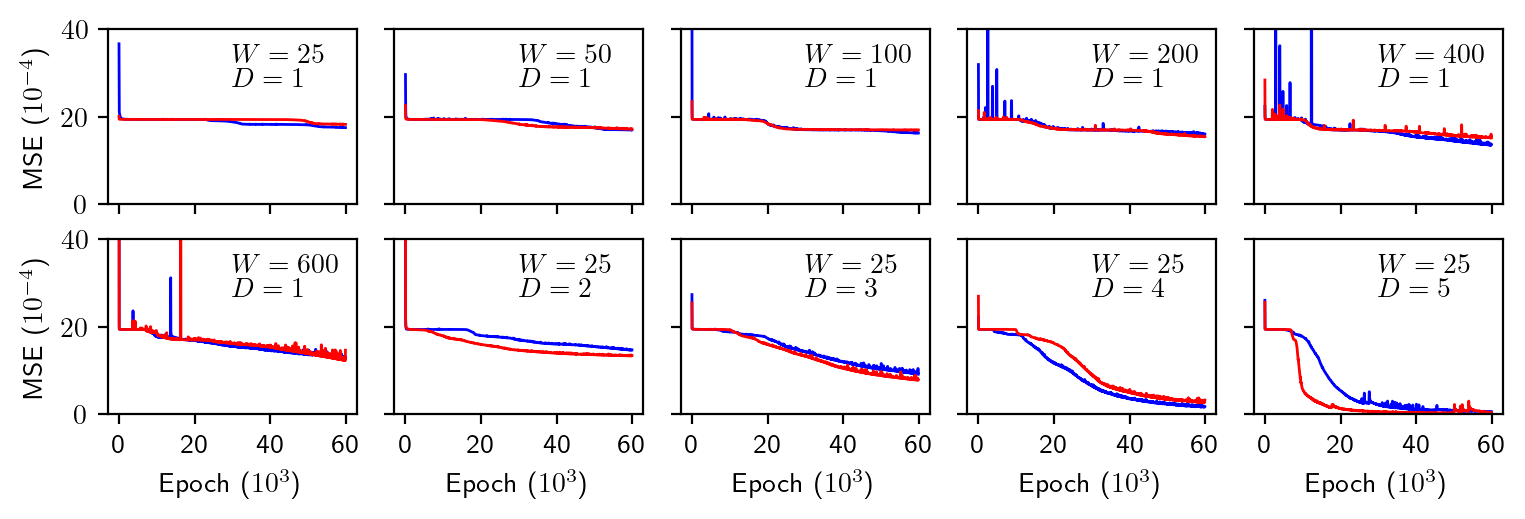

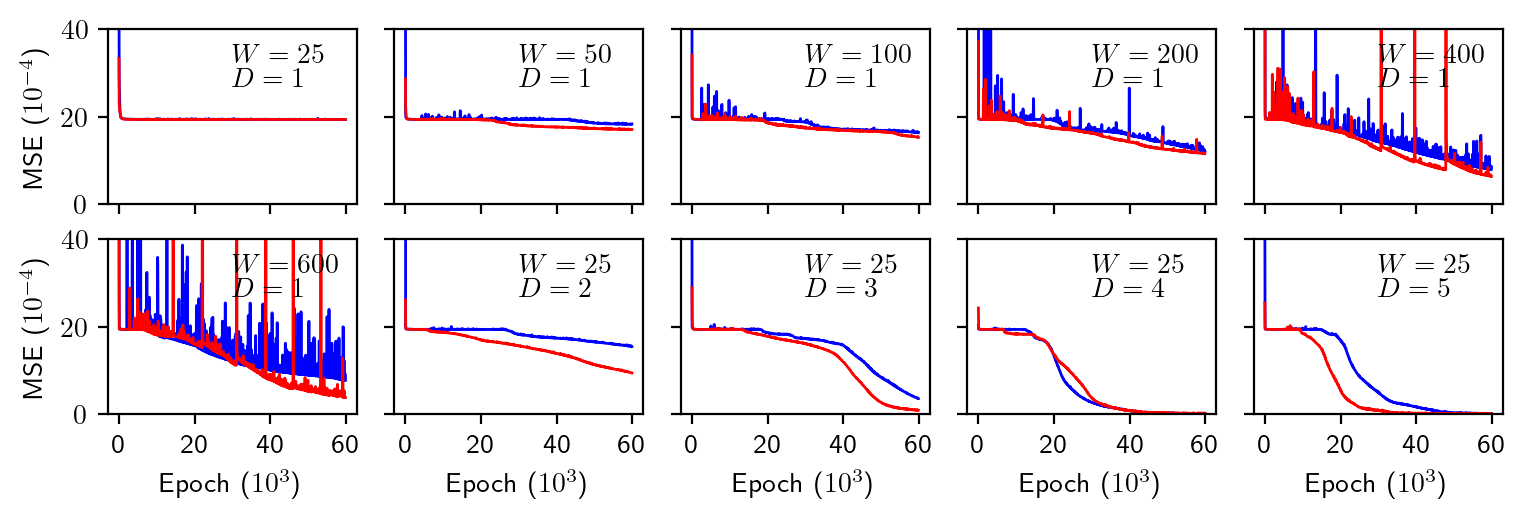

In [12]:
def moving_ave(series, window_size):
    """ Moving average to smooth the loss history a little bit """
    return np.convolve(series, np.ones(window_size) / window_size, mode='valid')


for act in ["relu", "leaky_relu", "gelu", "tanh"]:
    _, axes = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(9, 2.5), dpi=200)
    plt.subplots_adjust(wspace=.15)
    for i, (hidden_size_, num_hidden_layers_) in enumerate(nn_sizes):
        seed_ = 0
        hist_def = np.loadtxt(out_dir / f"{act}_{seed_}_{hidden_size_}_{num_hidden_layers_}_{False}")
        hist_kgi = np.loadtxt(out_dir / f"{act}_{seed_}_{hidden_size_}_{num_hidden_layers_}_{True}")
        ax = axes[i // 5, i % 5]
        p = 5
        ax.plot(np.arange(epochs // 20 - p // 2 - 2), moving_ave(hist_def, p) * 10000, label="No KGI", lw=1, c='b')
        ax.plot(np.arange(epochs // 20 - p // 2 - 2), moving_ave(hist_kgi, p) * 10000, label="KGI", lw=1, c='r')
        ax.text(.5, .92, f"$W={hidden_size_}$", va="top", ha="left", transform=ax.transAxes)
        ax.text(.5, .78, f"$D={num_hidden_layers_}$", va="top", ha="left", transform=ax.transAxes)

    axes[0, 0].set_ylim(0, 40)
    for i in range(2):
        axes[i, 0].set_ylabel("MSE ($10^{-4}$)")
    for i in range(5):
        axes[1, i].set_xlabel("Epoch ($10^3$)")
        axes[1, i].set_xticks([0, 20000 // 20, 40000 // 20, 60000 // 20], [0, 20, 40, 60])
    if act == "relu":
        axes[0, 0].legend(ncol=2, loc=[0.03, 0.04], handlelength=.8, columnspacing=.5, handletextpad=.4)
    plt.savefig(f"figs/surface_loss_epoch_{act}.pdf", bbox_inches='tight', pad_inches=0.01)
    plt.show()